In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready

from envs.photon_env import BatchedPhotonLangevinReadoutEnv
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv

from rl_algos.rl_wrappers import VecEnv

In [6]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [18]:
single_env = SinglePhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [19]:
### Timing for Single Env ###

rng = jax.random.PRNGKey(seed=30)
rng, rng_reset = jax.random.split(rng)

env_params = single_env.default_params

init_obs, init_state = single_env.reset(rng_reset, env_params)

dummy_action = jnp.ones_like(single_env.ts_action)

rng, rng_step = jax.random.split(rng)

obs, state, reward, done, info = single_env.step(rng_step, init_state, dummy_action, env_params)

start = time.time()
obs, state, reward, done, info = single_env.step(rng_step, init_state, dummy_action, env_params)
end = time.time()
time_taken = end - start
us = 1e-6
ms = 1e-3

print(f"Time taken for single action: {time_taken / ms}ms")

Time taken for single action: 3.9260387420654297ms


In [20]:
### Timing when vmapped ###

vec_env = VecEnv(single_env)

rng = jax.random.PRNGKey(seed=30)

num_envs = 1024

rng, _rng = jax.random.split(rng)
rng_reset = jax.random.split(_rng, num_envs)

vec_env_params = vec_env.default_params

init_vec_obs, init_vec_state = vec_env.reset(rng_reset, vec_env_params)

rng, _rng = jax.random.split(rng)
rng_step = jax.random.split(_rng, num_envs)

vec_action = jnp.tile(dummy_action, (num_envs,1))

obs, state, reward, done, info = vec_env.step(rng_step, init_vec_state, vec_action, env_params)

start = time.time()
obs, state, reward, done, info = vec_env.step(rng_step, init_vec_state, vec_action, env_params)
end = time.time()
time_taken = end - start

print(f"Time taken for {num_envs} vmapped actions: {time_taken / ms}ms")
print(f"Time taken per action: {time_taken / num_envs / us}us")

Time taken for 1024 vmapped actions: 210.74199676513672ms
Time taken per action: 205.80273121595383us


In [21]:
batched_env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=num_envs,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [22]:
### Comparing with Old Batched Environment

rng = jax.random.PRNGKey(seed=30)
rng, rng_reset = jax.random.split(rng)

batched_env_params = batched_env.default_params
init_obs, init_state = batched_env.reset(rng_reset, batched_env_params)

rng, rng_step = jax.random.split(rng)

obs, state, reward, done, info = batched_env.step(rng_step, init_state, vec_action, batched_env_params)

start = time.time()
obs, state, reward, done, info = batched_env.step(rng_step, init_state, vec_action, batched_env_params)
end = time.time()
time_taken = end - start

print(f"Time taken for {num_envs} vmapped actions: {time_taken / ms}ms")
print(f"Time taken per action: {time_taken / num_envs / us}us")

Time taken for 1024 vmapped actions: 239.8080825805664ms
Time taken per action: 234.18758064508438us


0
32
Vec: 419.5272922515869
Batched: 302.37436294555664
1
64
Vec: 303.36156487464905
Batched: 238.6718988418579
2
128
Vec: 253.1241625547409
Batched: 212.5166356563568
3
256
Vec: 229.7721803188324
Batched: 191.37095659971237
4
512
Vec: 203.65649834275246
Batched: 188.29666078090668
5
1024
Vec: 198.45040515065193
Batched: 184.83889289200306
6
2048
Vec: 216.45205561071634
Batched: 215.05227778106928


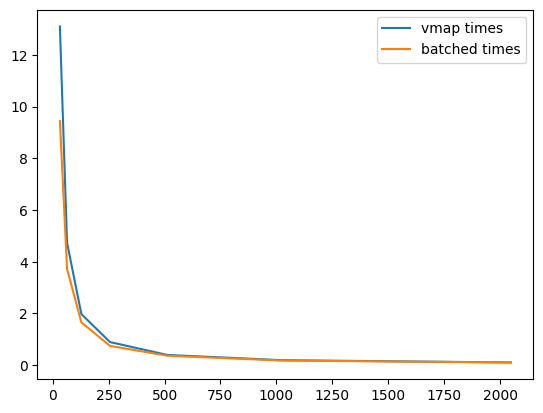

In [32]:
### Time Scaling Comparisons ###

num_envs_arr = jnp.array([32, 64, 128, 256, 512, 1024, 2048], dtype=jnp.int32)

vmap_time_arr = np.zeros_like(num_envs_arr)
batched_time_arr = np.zeros_like(num_envs_arr)

for i, (num_envs) in enumerate(num_envs_arr):
    rng = jax.random.PRNGKey(seed=30)
    rng, _rng = jax.random.split(rng)

    num_envs = int(num_envs)

    print(i)
    print(num_envs)

    batched_env = BatchedPhotonLangevinReadoutEnv(
        kappa=kappa,
        chi=chi,
        batchsize=num_envs,
        kerr=kerr,
        time_coeff=time_coeff,
        snr_coeff=snr_coeff,
        smoothness_coeff=smoothness_coeff,
        n0=n0,
        tau_0=tau_0,
        res_amp_scaling=res_amp_scaling,
        nR=nR,
        snr_scale_factor=snr_scale_factor,
        gamma_I=gamma_I,
        photon_gamma=photon_gamma,
        num_t1=num_t1,
        init_fid=init_fid,
        photon_weight=photon_weight,
    )

    rng_reset = jax.random.split(_rng, num_envs)

    _, vec_env_state = vec_env.reset(rng_reset, vec_env_params)
    _, batched_env_state = batched_env.reset(rng_reset, batched_env_params)

    rng, _rng = jax.random.split(rng)
    rng_step = jax.random.split(_rng, num_envs)

    test_action = jnp.tile(dummy_action, (num_envs, 1))

    obs, state, reward, done, info = batched_env.step(rng_step, batched_env_state, test_action, batched_env_params)
    obs, state, reward, done, info = vec_env.step(rng_step, vec_env_state, test_action, vec_env_params)

    start = time.time()
    obs, state, reward, done, info = vec_env.step(rng_step, vec_env_state, test_action, vec_env_params)
    end = time.time()
    time_per_us = (end - start) / num_envs / us
    print(f"Vec: {time_per_us}")
    vmap_time_arr[i] = time_per_us

    start = time.time()
    obs, state, reward, done, info = batched_env.step(rng_step, batched_env_state, test_action, batched_env_params)
    end = time.time()
    time_per_us = (end - start) / num_envs / us
    print(f"Batched: {time_per_us}")
    batched_time_arr[i] = time_per_us

plt.plot(num_envs_arr, vmap_time_arr, label='vmap times')
plt.plot(num_envs_arr, batched_time_arr, label='batched times')
plt.legend()
plt.show()

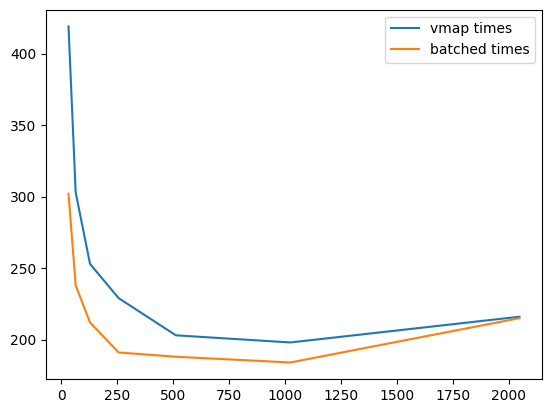

In [33]:
plt.plot(num_envs_arr, vmap_time_arr, label='vmap times')
plt.plot(num_envs_arr, batched_time_arr, label='batched times')
plt.legend()
plt.show()